In [3]:
# pip install mysql-connector-python

In [4]:
# pip install st-card

# CACHEJOIN

In [3]:
import mysql.connector
from collections import defaultdict
import threading
from threading import Thread
import time
from multiprocessing import Process
import sys
import random
import numpy as np
import pandas as pd
import warnings

In [4]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from numpy import cumsum
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
# >>> clf = linear_model.BayesianRidge()
from datetime import datetime
import plotly.express as px
from scipy.signal import savgol_filter
from scipy import stats
from dask import dataframe as dd
import plotly.graph_objects as go
from plotly.offline import iplot
import pickle
from scipy import ndimage
from tqdm import tqdm
import joblib

In [5]:
# md = pd.DataFrame(pd.read_csv('./sample_stream.csv')['P_key'].unique(), columns=['PartKey'])

In [6]:
# md.to_csv('sample_md.csv', index=False)

In [7]:
# md = pd.read_csv('./sample_md.csv')
# md

In [8]:
# md.rename(columns={'PartKey':'PartKey,'}, inplace=True)

In [9]:
# md['PartKey,'] = md['PartKey,'] + ','
# md

In [169]:
#to establish connection with MySQL
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Deviljin@202",
    database = "fyp"
)

In [170]:
#this function handles SQL query to extract data from MySQL
def executeQuery(query, selection, fetch):
    if fetch == 1:
        mycursor = mydb.cursor()
        mycursor.execute(query)
        if selection == 'all':
            myresult = mycursor.fetchall()
        elif selection == 'one':
            myresult = mycursor.fetchone()
        return myresult
    else:
        mycursor = mydb.cursor()
        mycursor.execute(query)
        return mycursor

In [171]:
#create cache to store IDs in cache for testing purposes
def createCache():
    cache = {}
    top100 = executeQuery('select PartKey from fyp1.sample_md limit 16000', 'all', 1)
    for i in top100:
        cache[i[0]] = 0
    return cache

In [172]:
cacheUsed = createCache()

In [173]:
def freqRecorder(new_id, freq):
    if new_id in freq.keys():
        freq[new_id] += 1
    else:
        freq[new_id] = 0
    return freq

In [174]:
def diskBuffer(query):
    dbuff = []
    mresult = executeQuery(query, 'all', 1)
    for i in mresult:
        pid = i[0]
#         print(pid)
        dbuff.append((pid))
    return dbuff

In [177]:
def replaceMin(dataCache, currKey, freq):
    #takes a dictionary as input and removes the key with the lowest value.
#     global dataCache
#     dataCache = updateWeights(dataCache, dt, features)
    min_pair = min(dataCache.items(), key=lambda x: x[1])
    key, value = min_pair
#     currKey, currVal = key_value
    if freq[currKey] > value:
#         print(dataCache[key], freq[currKey])
#         print(dataCache[key])
        del dataCache[key]
        dataCache[currKey] = freq[currKey]
#         dataCache.update({currKey: freq[currKey]})
#         print(dataCache[currKey], freq[currKey])
#         print(freq[currKey], ',', value)
#         print(dataCache[currKey])
    return dataCache

In [188]:
def streamBuffer(df, sbuff, dataCache, freq):
    cacheSize = 16000
    for i in range(len(df)):
        tid = df['Unnamed: 0'][i]
        pid = df['P_key'][i]
        date = df['streamDate'][i]    
        sbuff.append((tid, pid, date))
        #data flows through here so cache manipulation code will also be here
        #NOTE: the code isn't finished yet
        cacheKeys = dataCache.keys()
        currKey = pid
        freq = freqRecorder(currKey, freq)
#         if len(dataCache) >= cacheSize and currKey not in cacheKeys:
#             dataCache = replaceMin(dataCache, currKey, freq)
    return sbuff, dataCache

In [189]:
models = {'KNR':'./models/KNR.pkl', 
          'LR':'./models/LR.pkl', 
          'Decision Tree':'./models/DTree.pkl', 
          'Dummy Regressor':'./models/Dum.pkl'}

modelKeys = list(models.keys())

In [190]:
#mapping stream data into hashmap
def transactionMapping(streamBuff, mapp, queue):
    for i in streamBuff:
#         print(i)
        tid = i[0]
        pid = i[1]
        date = i[2]
        #previously, i was sent to stream/queue
        #join attribute sent to queue and mhm (key)
        queue.append(pid)
        mapp[pid].append((tid, pid, date))
        #Once a tuple makes it to the hashmap, it needs to be removed from the stream buffer
        streamBuff.remove((tid, pid, date))
    return queue, mapp, streamBuff

In [191]:
def searchAndJoin(diskBuff, bp, mapp, cache, counter, cache_count):
#     global probedPages
#     part = list(partition(diskBuff, bp))
#     l = len(part)
    required = 1000
    joinedPid = []
    for i in diskBuff:
#         for i in b:
        pid = i
#         print('in search and join (pid):',pid)
        for l in mapp[pid]:
            #Check and join using cache
            if pid in cache.keys():
                cache_count += 1
#                 print('cache joined:', pid)
                counter += 1
                #remove the matched tuples from the multi-value hashmap
                for j in mapp[pid]:
                    if j[0] in joinedTid:
                        mapp[pid].remove(j)
                        required -= 1
                joinedTid.append(l[0])
            #Join using disk
#             print('in search and join (mapp):', l)
            elif pid == l[1]:
                counter += 1
                #matching tuples joined
#                 print('joined:', pid)
                joinedTid.append(l[0])
                #remove the matched tuples from the multi-value hashmap
                for j in mapp[pid]:
                    if j[0] in joinedTid:
                        mapp[pid].remove(j)
                        required -= 1
                
                if mapp[pid] == []:
                    del mapp[pid]
#                 print('mhm after removal:', len(mapp))
    #the function returns counter which shows the number of tuples joined, an updated mhm, and the number of required tuples
    return counter, mapp, required, cache_count

In [192]:
#threading class for multithreading. We can run multiple functions in a parallel manner
class createThread(Thread):
    def __init__(self, group=None, target=None, name=None,
                 args=(), kwargs={}, Verbose=None):
        Thread.__init__(self, group, target, name, args, kwargs)
        self._return = None
    def run(self):
        print(type(self._target))
        if self._target is not None:
            self._return = self._target(*self._args, **self._kwargs)
    def join(self, *args):
        Thread.join(self, *args)
        return self._return

In [193]:
#store data in queue (linked list) and removes oldest tuples if queue is full
def queueRandRemoval(q, required):
    #if queue and streambuffer is full, then randomly remove queue nodes.
    num_to_remove = required
    indices_to_remove = sorted(random.sample(range(len(input_list)), num_to_remove))
    return [input_list[i] for i in range(len(input_list)) if i not in indices_to_remove]

In [194]:
import plotly.express as ex
import plotly.graph_objs as go

In [195]:
sb = []

tlimit1 = 0
tlimit2 = 50

limit1 = 0
limit2 = 10

counter = 0

mapping = defaultdict(list)
queue = []
dataset = []
joinedTid = []

probedPages = 0
bp = 5
b = 10

k = 0
start_time = time.time()

required = 1000
queueSize = 1000

dataCache = createCache()
cacheSize = 16000
hit = 0
miss = 0

tranQuery = ""

total_time = []
all_counts = []

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=[], y=[], mode='lines', name='time taken')
)
freq = {}
while(True):
    cache_count = 0
    if (counter >= 32000):
        break
    if (limit1 == 100):
        limit1 = 0
    
#     stream = []
    #this query gets stream data in batches to mimic as live data
    if len(sb) == 0:
        df = pd.read_csv('sample_stream.csv', skiprows=tlimit1, nrows=1000)
        tlimit1 += 1000
#         tranQuery = "select * from transactions " + " limit " + str(tlimit1) + ", " + str(tlimit2)
#         tlimit1 += 50
    elif len(sb) < 1000:
        df = pd.read_csv('sample_stream.csv',header = None, skiprows=tlimit1, nrows=1000-len(sb))
        df.rename(columns={0: 'Unnamed: 0', 1: 'ProductID', 2: 'P_key', 3: 'streamDate'}, inplace=True)
#         tranQuery = "select * from transactions " + " limit " + str(tlimit1) + ", " + str(50-len(sb))
        tlimit1 += len(sb)
    sb, dataCache = streamBuffer(df, sb, dataCache, freq)
#     print(sb)
    queue, mapper, sb = transactionMapping(sb, mapping, queue)
    
    if len(queue) == 1000:
        queue = queueRandRemoval(queue, 1000-len(sb))
    
    #get oldest attribute from queue which will be the index
    index = queue.pop(0)
#     print('mapper:',list(mapper.keys()))
#     print('queue:',queue)
#     print('index: ', index)
#     break
    
    masterQuery = "select * from fyp1.sample_md where PartKey >= '" + str(index) + "' limit 1000 offset 0"
    db = diskBuffer(masterQuery)
#     print('disk buffer size: ', db)
    probedPages = 0
    try:   
        counter, mapper, required, cache_count = searchAndJoin(db, bp, mapper, dataCache, counter, cache_count)
#         print("=====counter, size of stream buffer:", counter, ", ", len(sb) , "=================")
    except:
        print("incorrect key")
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    
#     if counter % 100 == 0:
#     print('in')
    total_time.append(time.time() - start_time)
#     temp = pd.DataFrame(total_time, columns=['time_taken'])
    all_counts.append(cache_count)
#     temp['joins'] = counter
#     plt.plot(xlabel=total_time, ylabel=all_counts)
        

#     tlimit1+=50
#     limit1+=10
    
    k+=1
#     break
print("Execution time:", (time.time() - start_time))

Execution time: 292.1509840488434


In [137]:
freq

{'14194_195': 9,
 '15929_195': 9,
 '8599_374': 9,
 '16023_556': 9,
 '3253_507': 9,
 '10869_650': 9,
 '16023_290': 9,
 '5009_775': 9,
 '18832_833': 9,
 '1751_505': 9,
 '7116_631': 9,
 '8925_184': 9,
 '10148_149': 9,
 '10373_894': 9,
 '11492_493': 9,
 '7096_868': 9,
 '5498_9': 9,
 '10660_441': 9,
 '13449_976': 9,
 '19995_996': 9,
 '14734_735': 9,
 '11899_422': 9,
 '9352_130': 9,
 '6388_901': 9,
 '16390_923': 9,
 '717_968': 9,
 '5372_373': 9,
 '16175_708': 9,
 '8388_389': 9,
 '8388_647': 9,
 '18419_956': 9,
 '8803_804': 9,
 '6747_260': 9,
 '18514_515': 9,
 '15708_239': 9,
 '13968_232': 9,
 '5396_397': 9,
 '5396_162': 9,
 '10373_374': 9,
 '13006_270': 9,
 '5977_978': 9,
 '2147_652': 9,
 '14262_791': 9,
 '8624_883': 9,
 '18821_90': 9,
 '4208_717': 9,
 '15393_659': 9,
 '5966_967': 9,
 '7953_211': 9,
 '11716_717': 9,
 '9420_939': 9,
 '6947_460': 9,
 '7251_252': 9,
 '18391_660': 9,
 '18454_723': 9,
 '13510_774': 9,
 '8686_687': 9,
 '104_355': 9,
 '5147_403': 9,
 '4584_347': 9,
 '166_167': 9,
 

In [168]:
for i in dataCache.keys():
    if dataCache[i] >= 1:
        print(i, dataCache[i])

8599_374 1
6747_260 1
3253_507 1
717_968 1
16390_923 1
8720_721 1
5498_9 1
4458_967 1
18775_580 1
8624_883 1
7497_755 1
9143_662 1
15771_567 1
17398_666 1
3987_241 1
7089_90 1
14262_791 1
13689_216 1
16885_886 1
18454_723 1
7953_211 1
7251_252 1
15393_659 1
15936_732 1
15143_144 1
14734_735 1
9933_193 1
5396_162 1
5396_397 1
19531_801 1
16104_371 1
2147_652 1
14696_961 1
14696_489 1
17321_322 1
7814_72 1
15603_869 1
4235_490 1
4235_744 1
17286_88 1
3018_525 1
15944_740 1
2483_736 1
611_612 1
1642_894 1
4425_680 1
16519_318 1
18149_686 1
13959_486 1
7591_592 1
13755_756 1
4512_767 1
7586_101 1
4208_717 1
3415_175 1
17795_597 1
1716_968 1
648_149 1
13685_475 1
18496_497 1
18530_335 1
15649_180 1
8348_123 1
1502_754 1
13968_232 1
18419_956 1
14369_370 1
3567_74 1
3567_821 1
14154_947 1
2166_167 1
2991_992 1
19767_306 1
6115_628 1
6115_884 1
8276_793 1
17002_3 1
8803_804 1
18579_384 1
401_402 1
9263_264 1
5152_918 1
19583_122 1
3153_154 1
8936_453 1
9699_477 1
19667_475 1
19411_950 1
2001_

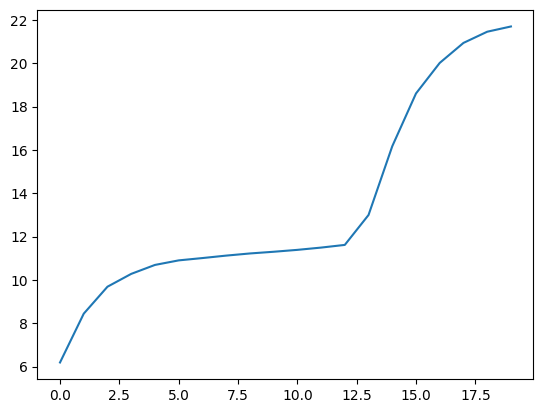

In [83]:
plt.plot(total_time)

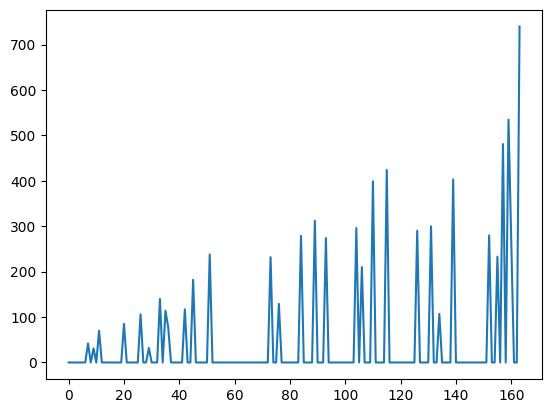

In [197]:
plt.plot(all_counts)

In [196]:
dataCache

{'1_2': 0,
 '1_252': 0,
 '1_502': 0,
 '1_752': 0,
 '10_11': 0,
 '10_261': 0,
 '10_511': 0,
 '10_761': 0,
 '100_101': 0,
 '100_351': 0,
 '100_601': 0,
 '100_851': 0,
 '1000_1': 0,
 '1000_251': 0,
 '1000_501': 0,
 '1000_751': 0,
 '10000_1': 0,
 '10000_260': 0,
 '10000_519': 0,
 '10000_778': 0,
 '10001_2': 0,
 '10001_262': 0,
 '10001_522': 0,
 '10001_782': 0,
 '10002_263': 0,
 '10002_3': 0,
 '10002_523': 0,
 '10002_783': 0,
 '10003_264': 0,
 '10003_4': 0,
 '10003_524': 0,
 '10003_784': 0,
 '10004_265': 0,
 '10004_5': 0,
 '10004_525': 0,
 '10004_785': 0,
 '10005_266': 0,
 '10005_526': 0,
 '10005_6': 0,
 '10005_786': 0,
 '10006_267': 0,
 '10006_527': 0,
 '10006_7': 0,
 '10006_787': 0,
 '10007_268': 0,
 '10007_528': 0,
 '10007_788': 0,
 '10007_8': 0,
 '10008_269': 0,
 '10008_529': 0,
 '10008_789': 0,
 '10008_9': 0,
 '10009_10': 0,
 '10009_270': 0,
 '10009_530': 0,
 '10009_790': 0,
 '1001_2': 0,
 '1001_253': 0,
 '1001_504': 0,
 '1001_755': 0,
 '10010_11': 0,
 '10010_271': 0,
 '10010_531': 0,


In [68]:
freq

{'14194_195': 19,
 '15929_195': 9,
 '8599_374': 9,
 '16023_556': 19,
 '3253_507': 9,
 '10869_650': 9,
 '16023_290': 19,
 '5009_775': 9,
 '18832_833': 9,
 '1751_505': 9,
 '7116_631': 9,
 '8925_184': 9,
 '10148_149': 19,
 '10373_894': 9,
 '11492_493': 9,
 '7096_868': 9,
 '5498_9': 9,
 '10660_441': 29,
 '13449_976': 19,
 '19995_996': 9,
 '14734_735': 9,
 '11899_422': 9,
 '9352_130': 19,
 '6388_901': 9,
 '16390_923': 19,
 '717_968': 19,
 '5372_373': 9,
 '16175_708': 21,
 '8388_389': 9,
 '8388_647': 9,
 '18419_956': 19,
 '8803_804': 9,
 '6747_260': 9,
 '18514_515': 19,
 '15708_239': 19,
 '13968_232': 9,
 '5396_397': 9,
 '5396_162': 9,
 '10373_374': 9,
 '13006_270': 9,
 '5977_978': 9,
 '2147_652': 29,
 '14262_791': 12,
 '8624_883': 9,
 '18821_90': 29,
 '4208_717': 19,
 '15393_659': 19,
 '5966_967': 9,
 '7953_211': 9,
 '11716_717': 9,
 '9420_939': 9,
 '6947_460': 9,
 '7251_252': 9,
 '18391_660': 29,
 '18454_723': 29,
 '13510_774': 9,
 '8686_687': 9,
 '104_355': 19,
 '5147_403': 9,
 '4584_347'

In [57]:
print("Execution time:", (time.time() - start_time))

Execution time: 1355.4731628894806


In [105]:
counter

4889

In [51]:
freq

{'14194_195': 9,
 '15929_195': 9,
 '8599_374': 9,
 '16023_556': 9,
 '3253_507': 9,
 '10869_650': 9,
 '16023_290': 9,
 '5009_775': 9,
 '18832_833': 9,
 '1751_505': 9,
 '7116_631': 9,
 '8925_184': 9,
 '10148_149': 9,
 '10373_894': 9,
 '11492_493': 9,
 '7096_868': 9,
 '5498_9': 9,
 '10660_441': 9,
 '13449_976': 9,
 '19995_996': 9,
 '14734_735': 9,
 '11899_422': 9,
 '9352_130': 9,
 '6388_901': 9,
 '16390_923': 9,
 '717_968': 9,
 '5372_373': 9,
 '16175_708': 9,
 '8388_389': 9,
 '8388_647': 9,
 '18419_956': 9,
 '8803_804': 9,
 '6747_260': 9,
 '18514_515': 9,
 '15708_239': 9,
 '13968_232': 9,
 '5396_397': 9,
 '5396_162': 9,
 '10373_374': 9,
 '13006_270': 9,
 '5977_978': 9,
 '2147_652': 9,
 '14262_791': 9,
 '8624_883': 9,
 '18821_90': 9,
 '4208_717': 9,
 '15393_659': 9,
 '5966_967': 9,
 '7953_211': 9,
 '11716_717': 9,
 '9420_939': 9,
 '6947_460': 9,
 '7251_252': 9,
 '18391_660': 9,
 '18454_723': 9,
 '13510_774': 9,
 '8686_687': 9,
 '104_355': 9,
 '5147_403': 9,
 '4584_347': 9,
 '166_167': 9,
 

In [44]:
dataCache['14194_195'] = freq['14194_195']

In [47]:
len(dataCache)

16000

In [ ]:
df = pd.read_csv('sample_stream.csv', header = None, skiprows=tlimit1, nrows=50)

In [84]:
st = pd.read_csv('./sample_stream.csv')[['P_key']]
st

,P_key
0,14194_195
1,15929_195
2,8599_374
3,16023_556
4,3253_507
...,...
5870325,13035_562
5870326,2603_604
5870327,11883_406
5870328,2309_310


In [85]:
st[st['P_key'] == 17795]

,P_key


Without cache: 22-23 s

With cache: 15-16 s

In [27]:
d = {'key0': 'value1', 'key2': 'value2', 'key3': 'value3'}
oldest_key = min(d.keys())
print(oldest_key)

key0


In [52]:
def remove_random_elements(input_list, num_to_remove):
    if num_to_remove >= len(input_list):
        raise ValueError("Can't remove more elements than there are in the list.")
    indices_to_remove = sorted(random.sample(range(len(input_list)), num_to_remove))
    return [input_list[i] for i in range(len(input_list)) if i not in indices_to_remove]

# Example usage
my_list = [1, 2, 3, 4, 5]
new_list = remove_random_elements(my_list, 3)
print(new_list) # Outputs e.g. [1, 2, 5]

[3, 5]


In [170]:
pk = '14194_195'
md = pd.read_csv('sample_md.csv').query('PartKey >= @pk')

In [171]:
r = open('./sample_md.csv')

In [90]:
st = pd.read_csv('sample_stream.csv', skiprows=tlimit1, nrows=50)
st

,10324,18897,18897_702,1992-01-02
0,10325,19360,19360_168,1992-01-02
1,10326,4361,4361_362,1992-01-02
2,10327,18625,18625_162,1992-01-02
3,10328,15300,15300_301,1992-01-02
4,10329,9357,9357_617,1992-01-02
5,10330,12507,12507_294,1992-01-02
6,10331,19360,19360_168,1992-01-02
7,10332,17413,17413_681,1992-01-02
8,10333,339,339_590,1992-01-02
9,10334,18683,18683_488,1992-01-02


In [91]:
st = pd.read_csv('sample_stream.csv')

,Unnamed: 0,L_PARTKEY,P_key,streamDate
0,0,14194,14194_195,1992-01-01
1,1,15929,15929_195,1992-01-01
2,2,8599,8599_374,1992-01-01
3,3,16023,16023_556,1992-01-01
4,4,3253,3253_507,1992-01-01
...,...,...,...,...
5870325,5870325,13035,13035_562,1998-04-30
5870326,5870326,2603,2603_604,1998-04-30
5870327,5870327,11883,11883_406,1998-04-30
5870328,5870328,2309,2309_310,1998-04-30


In [92]:
st.rename(columns={0: 'Unnamed: 0', 1: 'P_key', 2: 'streamDate'}, inplace=True)

In [93]:
st

,Unnamed: 0,L_PARTKEY,P_key,streamDate
0,0,14194,14194_195,1992-01-01
1,1,15929,15929_195,1992-01-01
2,2,8599,8599_374,1992-01-01
3,3,16023,16023_556,1992-01-01
4,4,3253,3253_507,1992-01-01
...,...,...,...,...
5870325,5870325,13035,13035_562,1998-04-30
5870326,5870326,2603,2603_604,1998-04-30
5870327,5870327,11883,11883_406,1998-04-30
5870328,5870328,2309,2309_310,1998-04-30


In [95]:
pd.read_csv('sample_stream.csv', skiprows=None, nrows=50)

,Unnamed: 0,L_PARTKEY,P_key,streamDate
0,0,14194,14194_195,1992-01-01
1,1,15929,15929_195,1992-01-01
2,2,8599,8599_374,1992-01-01
3,3,16023,16023_556,1992-01-01
4,4,3253,3253_507,1992-01-01
5,5,10869,10869_650,1992-01-01
6,6,16023,16023_290,1992-01-01
7,7,5009,5009_775,1992-01-01
8,8,18832,18832_833,1992-01-01
9,9,1751,1751_505,1992-01-01


In [112]:
import time
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.offline import iplot

# create empty lists to store data
total_time = []
all_counts = []
counter = 0

# create the plot with an empty trace
fig = sp.make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=[], y=[], mode='lines', name='time taken'), row=1, col=1)

# display the initial empty plot
iplot(fig)

while True:
    start_time = time.time()
    # do some operation
    time.sleep(1)
    counter += 1
    
    # append data
    total_time.append(time.time() - start_time)
    all_counts.append(counter)
    
    # create the new trace with the updated data
    trace = go.Scatter(x=all_counts, y=total_time, mode='lines', name='time taken')
    
    # update the plot using batch_update()
    fig.update_layout(title=f'Time taken for {counter} iterations')
    fig.for_each_trace(lambda trace: trace.visible=False)
    fig.add_trace(trace, row=1, col=1)
    fig.for_each_trace(lambda trace: trace.update(visible=True))
    fig.layout.autosize = False
    fig.layout.width = 800
    fig.layout.height = 500
    fig.layout.xaxis.title = 'counts'
    fig.layout.yaxis.title = 'time taken'
    fig.layout.margin = {'l': 40, 'r': 10, 't': 50, 'b': 30}
    
    # display the updated plot
    iplot(fig)


SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (400573520.py, line 33)